# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [266]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math
from datetime import datetime as dt
import re as re

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

In [2]:
# Basic EDA
# The training data needs to be saved in the same location.
original_data = pd.read_csv('train.csv')
data = original_data.copy()

# Background to the problem

### The Dataset and Framing the Problem

The goal of this problem is to use the Ames Housing Dataset to create a model to predict the sale prices of homes randomly selected from within the original dataset. 

The Ames Housing Dataset was compiled by Dean De Cock in 2011. It is based on all the housing sales that occured in Ames, Iowa during the period from 2006 to 2010. It was created as an alternative to the Boston Housing Dataset and it includes more feature variables (79) that are related to housing price. The original dataset included 2,390 observations. The goal of the creator was to include a wider set of explanatory variables than the original Boston Housing Dataset to allow for more advanced regression techniques to be applied.

The problem itself is based on Kaggle competition to use advanced regression techniques to create a model to predict the sale price of a home. The test data is randomly selected from within the original Ames Housing Dataset. The training dataset used in the Kaggle competition includes 1,460 observations. The goal is to accurately predict the sale prices of the homes in the test set.

### Housing Price Trends over Time

In order to understand the effect of the overall economy on housing prices within Ames, Iowa during this time period, we look at both the trends within our data and within the country as a whole. We start by looking at trends in our own data set.

In [3]:
train_data = original_data

Text(0,0.5,'Median Prices')

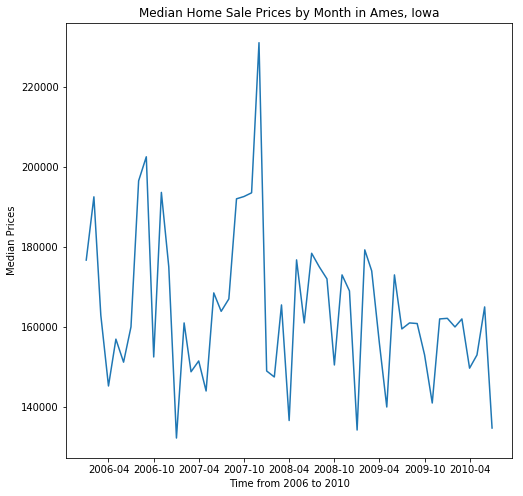

In [4]:
dates = []

for i in range(len(train_data["YrSold"])):
    dt = datetime.datetime(year = train_data["YrSold"][i], month = train_data["MoSold"][i], day = 1 )
    dates.append(dt)

train_data["DateSold"] = dates

month_medians = train_data.groupby('DateSold')['SalePrice'].median()
plt.figure(figsize=(8,8))
plt.plot(month_medians.index, month_medians)
plt.title('Median Home Sale Prices by Month in Ames, Iowa')
plt.xlabel('Time from 2006 to 2010')
plt.ylabel('Median Prices')

Looking at the medians by month, we do see sharp decline in 2008, which corresponds to the beginning of the housing crisis, and a peak right before the crisis. It is worth noting that the housing crisis may have effected housing prices in this data set. Comparing the data from Ames, Iowa over this time to the home prices in the nation over the same time period shows that the prices in Ames, Iowa appear to have been much more stable during the housing crisis.

Below, we look at data from the Federal Reserve showing the S&P/Case-Schiller National Home Price Index. This helps us understand larger context of housing prices over time.

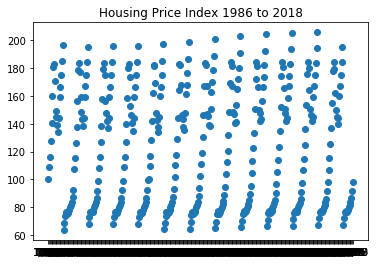

In [5]:
# todo: fix the dates to be legible
housing_data = pd.read_csv("housing_prices.csv")
plt.plot_date(x = housing_data['DATE'], 
              y = housing_data['CSUSHPINSA'], 
              xdate=True, 
              ydate=False, 
              data= housing_data)
plt.title("Housing Price Index 1986 to 2018")
plt.show()

This shows a significant change in housing prices right around the time period we are looking at, from 2006 to 2010. Let's look at this portion of the graph in more detail.

Text(0.5,1,'Housing Price Index 2006 to 2010')

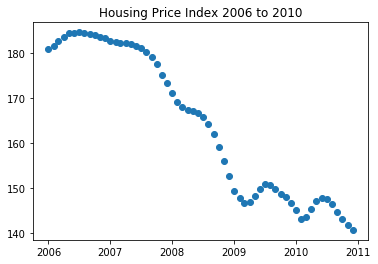

In [6]:
housing_data['DATE'] =  pd.to_datetime(housing_data['DATE'])
housing_data["YEAR"] = housing_data["DATE"].dt.year

housing_data_2006_2010 = housing_data[ (housing_data["YEAR"] >= 2006) & (housing_data["YEAR"] <= 2010)]
plt.plot_date(x = housing_data_2006_2010['DATE'], 
              y = housing_data_2006_2010['CSUSHPINSA'], 
              xdate=True, 
              ydate=False, 
              data= housing_data_2006_2010)

plt.title("Housing Price Index 2006 to 2010")

Overall, this analysis suggests that while there were significant trends in the overall US housing market during the 3 year window in with the data was collected, these trends might not have a significant impact on the data in our dataset. However, it is still worth considering how the economic climate overall would affect housing prices.

### Distribution of Sale Price Variable

First we look at the distribution of the sale price variable using a histogram.

Text(0.5,0,'Sale Prices')

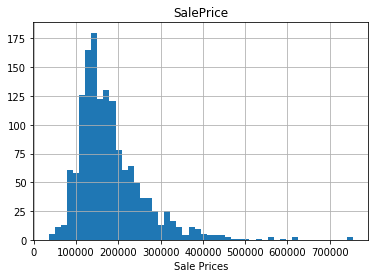

In [7]:
train_data.hist("SalePrice", bins = 50)
plt.xlabel("Sale Prices")

In [8]:
train_data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The distribution of the target variable above shows a right-hand skew with a few very large outliers. This initial display suggests that it might be possible to exclude some of the more expensive homes from the training data set, or to possibly create a model that makes different predictions based on whether the home falls into the average range or not.

We can also look at the log of the sales prices to see how this changes the distribution of the target variable. The goal is to create a more normal distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aa02e10>]],
      dtype=object)

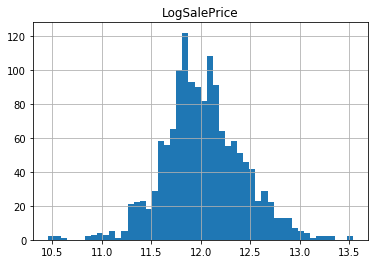

In [9]:
train_data["LogSalePrice"] = np.log(train_data["SalePrice"])
train_data.hist("LogSalePrice", bins = 50)

This produces a more normally distributed set of data. This makes our highly skewed distribution less skewed and allows our sale price data to meet the assumptions of inferential statistics and linear regression.

### Interpretability vs Accuracy

The goal of the Kaggle competiion is to create the most accurate model for predicting the sales price of the testing data. The model that produces the most accurate predictions might not necessarily be the most user-friendly or interpretable model for people actually seeking to use the model in the real world. For instance, real estate brokers or home buyers might be interested in a model that provided less accuracy in terms of exact predictions but more interpretability in terms of using it to make real-time decisions about how much to offer for a given home.

An ideal solution to this problem would not only involve predicting future home prices, which would thus involve weighting recent sales more heavily than older sales, but would also involve various tiers of interpretability for different use cases. For instance, for lay-person home buyers or sellers trying to estimate the value of home, a very interpretable model with fewer included features would be more useful. However, for real estate professionals such as agents or developers, a more accurate model might be worth the additional computing power needed because these decision makers might have access to more resources.

### Exploratory Data Analysis

Let's look at the data to understand its structure.

In [10]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DateSold,LogSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,2008-02-01,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,2007-05-01,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,2008-09-01,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,2006-02-01,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,2008-12-01,12.429216


We see that we have the original 79 features and the target of SalePrice, along with the ID column, the date and the log of the sale price. Each row represents a home that was sold in Ames, Iowa during the time period of 2006 through 2010. We also see below that there are 1,460 observations.

In [11]:
train_data.shape

(1460, 83)

Let's look at the relationship of a few key variables to the target variable. First we do a basic check of the correlations between the numeric variables and the target variable to identify some key variables to explore. According to Random Forest, the most important features are the OverallQuality and the FirstFloorLiving Area. 

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b09d1d0>,
      dtype=object)

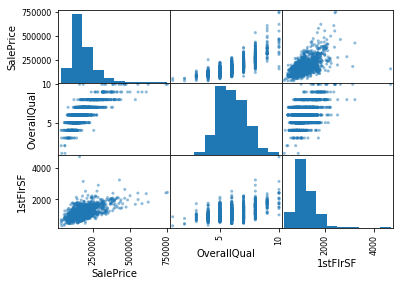

In [12]:
attributes = ["SalePrice", "OverallQual", "1stFlrSF"]
pd.scatter_matrix(train_data[attributes], figsize=(6,4))

This scatter matrix shows a strong correlation between the key variables of interest and the target variable, which is what we would expect. For instance, in the scatterplot of Overall Quality vs Sale Price, we see that increases in Overall Quality lead to clear increases in the Sale Price, with some exceptions for houses with the high quality--there appears to be a bigger range of sale prices for home with higher quality ratings. There is a similar relationship between the 1st Floor Square Feet and the Sale Price.

## Feature Engineering

### Overview

We have two broad approaches to feature engineering - 'top down' and 'bottom up'. 

In the 'top down' case, we start with all the variables and work to eliminate / simplify variables as much as possible. We remove features with little useful variation (mostly missing, or heavily imbalanced) and features that are highly correlated for obvious reasons (e.g. total square feet and other component square feet). These should help to reduce the likelihood of overfitting and help improve interpretability. 

In the 'bottom up' case, we use various algorithmic feature selection techniques (e.g. random forest feature importance) and choose the top 10. This helps us construct the most parsimonious feature set to compare our more complete feature set against. 

In both cases, we also make several variable transformations - imputing missing features, or one-hot-encoding categorical features, for instance. They are listed below. 

### Remove features with very little variation and those that are missing for most observations

Based on this heatmap of missing variables we see that Alley, PoolQC, Fence and MiscFeature are missing for most values in the dataset. This makes sense, as these are more esoteric features of the house. In the same vein, there is also very little variation in Street, Utilities, LowQualFinSF and MiscVal. For example, most of these houses have all the utilities except for one. While this may ultimately be an important predictor, we believe that this is more likely to overfit and not generalize (after all this observation can only be in validation or train) for any given fold.

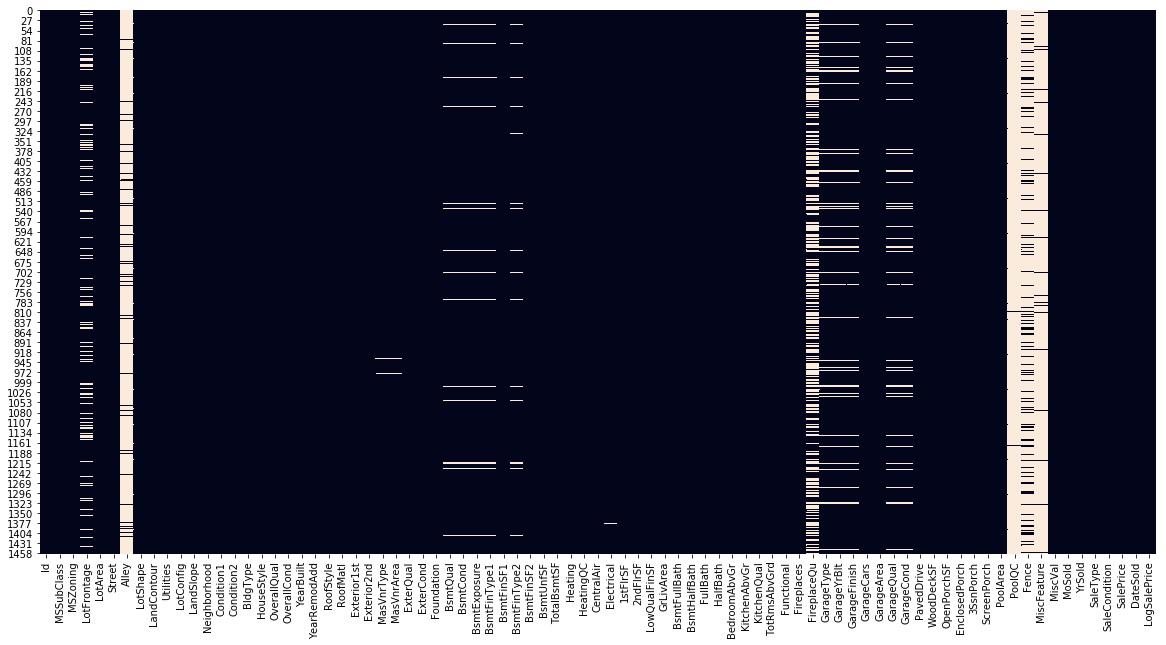

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
data = data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop variables with very imblanced categories or mostly missing
data = data.drop(columns = ['Street', 'Utilities', 'LowQualFinSF', 'MiscVal'])

### Remove features that are redundant given other variables

We then remove aggregated variables that are very close to the sum of its component parts. For instance, TotalBsmtSF is the approximately sum of the BsmtFinSF1, BSmtUnfSF and BsmtFinSF2. Likewise with GrLivArea. There are some minor discrepancies, but I assume that those are immaterial for our analysis and not large/frequent enough to matter. 

GarageArea / GarageCars is an interesting case, as these two variables capture a similar concept. Indeed, the two variables are highly correlated (see chart below). We keep both in for now, but may decide to remove the 'less informative' one later (e.g. GarageCars). 

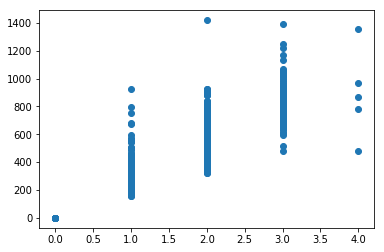

In [14]:
##################
### BASEMENTSF ###
# Drop the aggregate BsmtSF variable
test = pd.DataFrame()
test['DiffBsmtSF'] = original_data["TotalBsmtSF"] - original_data['BsmtFinSF1'] - original_data['BsmtUnfSF'] - original_data['BsmtFinSF2']
test['DiffBsmtSF'].value_counts()

# Remove variable
data = data.drop(columns=['TotalBsmtSF'])

##################
### GRLIVAREA ###
# Is GrLivArea simply the sum of 1st and 2nd?
# Most of hte time it is - there are 5 observations that are not, but doesn't seem like a goood reason to keep
test = pd.DataFrame()
test['GrLivArea'] = original_data["GrLivArea"]
test['1stAnd2nd'] = original_data["1stFlrSF"] + original_data["2ndFlrSF"]
test['Diff'] = test['GrLivArea'] - test['1stAnd2nd']
test['Diff'].value_counts()

###################
### GARAGECARS ###
data = data.drop(columns = ['GrLivArea'])
original_data['GarageCars'].value_counts()
plt.scatter(original_data['GarageCars'],original_data['GarageArea'])
#data = data.drop(columns=['GarageCars']) # KEEP FOR NOW, but garage area may be better than garage cars

###################
### DATETIME    ###
# Change date to ordinal representation:
data['YrMoSold'] = data['YrSold'].astype(int).astype(str) + "/" + data['MoSold'].astype(int).astype(str) + "/1"
data['YrMoSold'] = data['YrMoSold'].apply(lambda x: dt.strptime(x, "%Y/%m/%d").date().toordinal())

### Impute features

We use the median values to impute missing values to control for possible outliers. We also do not impute any missing categories for now (they will receive 0 across all one-hot encoded dummy variables). In a later analysis, we might do more complex imputation of these missing values. 

In [15]:
#############################
# Impute all numeric missings (all dummy missings are coded 0)
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
data_numeric = imp.fit_transform(data.select_dtypes(exclude='object'))
data_numeric = pd.DataFrame(data_numeric, columns = data.select_dtypes(exclude='object').columns)
data = pd.concat([data.select_dtypes(include='object'), data_numeric], axis = 1)

### Combine sparse categories in some features

Condition and Exterior features have many sparse levels - we group levels that have very few observations to obtain a bigger category. 

In [16]:
# Combine categories - very thin categories
# Condition1
data['Condition1'] = np.where(data['Condition1']=='Norm', 'Norm', 'Not_Norm')
data['Condition2'] = np.where(data['Condition2']=='Norm', 'Norm', 'Not_Norm')

# Exterior1st
data['Exterior1st'] = np.where(data['Exterior1st'].isin(['BrkComm', 'Stone', 'AsphShn', 'ImStucc', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])
data['Exterior2nd'] = np.where(data['Exterior2nd'].isin(['Brk Cmn', 'Stone', 'AsphShn', 'Other', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])


### One-Hot-Encoding for Categoricals

We use one-hot encoding to encode categorical features and combine the condition and exterior variables into one variable each. 

In [17]:
##########################
# Binarize all categorical (one-hot)
data = pd.get_dummies(data)

In [18]:
# Simplify the Condition Feature
data['Condition_Norm'] = data['Condition1_Norm'] + data['Condition2_Norm']
data['Condition_Not_Norm'] = data['Condition1_Not_Norm'] + data['Condition2_Not_Norm']
data['Condition_Norm'] = np.where(data['Condition_Norm']==2, 1, data['Condition_Norm'])
data['Condition_Not_Norm'] = np.where(data['Condition_Not_Norm']==2, 1, data['Condition_Not_Norm'])

# Simplify the Exterior Feature
data['Exterior_VinylSd'] = data['Exterior1st_VinylSd'] + data['Exterior2nd_VinylSd']
data['Exterior_HdBoard'] = data['Exterior1st_HdBoard'] + data['Exterior2nd_HdBoard']
data['Exterior_MetalSd'] = data['Exterior1st_MetalSd'] + data['Exterior2nd_MetalSd']
data['Exterior_Wd Sdng'] = data['Exterior1st_Wd Sdng'] + data['Exterior2nd_Wd Sdng']
data['Exterior_Plywood'] = data['Exterior1st_Plywood'] + data['Exterior2nd_Plywood']
data['Exterior_Other']   = data['Exterior1st_Other']   + data['Exterior2nd_Other']
data['Exterior_CemntBd'] = data['Exterior1st_CemntBd'] + data['Exterior2nd_CemntBd']
data['Exterior_BrkFace'] = data['Exterior1st_BrkFace'] + data['Exterior2nd_BrkFace']

data['Exterior_VinylSd'] = np.where(data['Exterior_VinylSd'] == 2, 1, data['Exterior_VinylSd'])
data['Exterior_HdBoard'] = np.where(data['Exterior_HdBoard'] == 2, 1, data['Exterior_HdBoard'])
data['Exterior_MetalSd'] = np.where(data['Exterior_MetalSd'] == 2, 1, data['Exterior_MetalSd'])
data['Exterior_Wd Sdng'] = np.where(data['Exterior_Wd Sdng'] == 2, 1, data['Exterior_Wd Sdng'])
data['Exterior_Plywood'] = np.where(data['Exterior_Plywood'] == 2, 1, data['Exterior_Plywood'])
data['Exterior_Other'] = np.where(data['Exterior_Other'] == 2, 1, data['Exterior_Other'])
data['Exterior_CemntBd'] = np.where(data['Exterior_CemntBd'] == 2, 1, data['Exterior_CemntBd'])
data['Exterior_BrkFace'] = np.where(data['Exterior_BrkFace'] == 2, 1, data['Exterior_BrkFace'])

cols_to_drop = list(filter(lambda x: re.search(r'Condition1|Condition2|Exterior1|Exterior2', x), data.columns))
data = data.drop(columns=cols_to_drop)

### Convert features to the right type

In [19]:
data['OverallQual'] = original_data['OverallQual'].astype('category')
data['OverallCond'] = original_data['OverallCond'].astype('category', ordered=True)
data['MSSubClass'] = original_data['MSSubClass'].astype('category')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


### Add new features

In [226]:
data['Basement'] = np.where(data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF'] > 1, 1, 0)
data['WoodDeck'] = np.where(data['WoodDeckSF'] > 0, 1, 0)

### Some basic feature importance to sense check

We do two types of feature importance checks:
- First we investigate the pairwise correlation between all variables and identify any set variables that are highly correlated. This led us to discover the redundant sets of variables discussed above.
- Second we use the Random Forest feature importance algorithm to identify the variables that lead to the largest information gain. This mostly makes sense and we use this to construct the 'bottom up' dataset. 

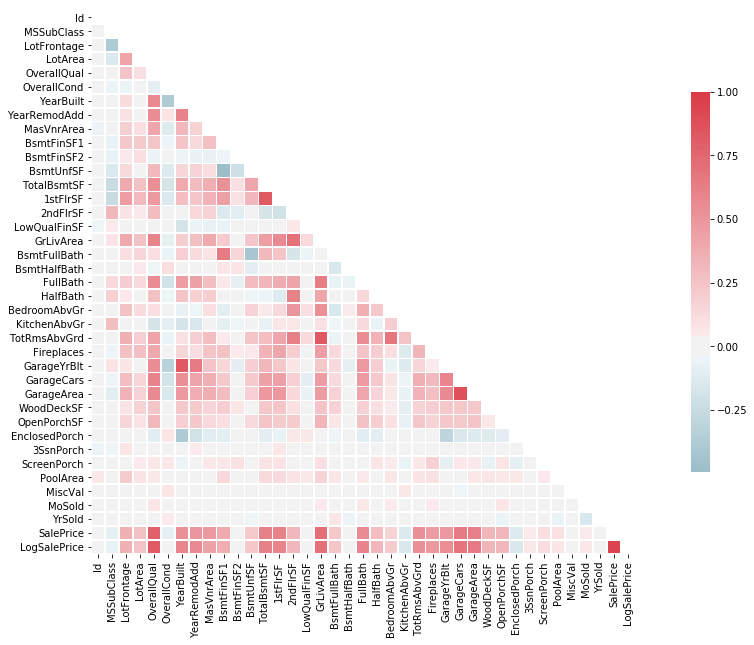

In [21]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Use an algorithmic Feature Selection method

In [22]:
remove_variables = ['SalePrice']

rf = RandomForestRegressor()
rf.fit(data.drop(columns=['SalePrice']), data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = data.drop(columns=['SalePrice']).columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances[0:10]

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
OverallQual,0.5856
1stFlrSF,0.0487
2ndFlrSF,0.0462
GarageCars,0.0392
BsmtFinSF1,0.0353
LotArea,0.0330
GarageArea,0.0325
TotRmsAbvGrd,0.0196
BsmtQual_Ex,0.0151
WoodDeckSF,0.0098


### Create a Simple Version with fewer variables

In [23]:
### Create a really simple version with 10 variables
most_impt_cols = list(feature_importances[:10].index)
most_impt_cols.append('SalePrice')

def get_simple_data(input_data, colnames):
    output_data = input_data[colnames]
    return(output_data)
    
simple_data = get_simple_data(data, most_impt_cols)

--------

# Run Baseline & Early Models

We started with a simple 15% dev set, but we have found that for this amount of data, the differences in the models and their scores on the dev sets can vary significantly based on which rows end up in the train and dev sets. Repeated random sub-sampling cross validation helps us get more consistent results.

Note that we do not split out the dev data using the most recent years, which would be the proper way to create a dev set if our task were explicitly to predict future home prices. The test data appears to have rows from all the years represented in the train set, so we built dev sets that sample from across the train set. 

In [227]:
# still to do : choose one version of pandas to use so that our code all agrees
# and I don't have to read in a new dataset here 
data['LogSalePrice'] = np.log(data['SalePrice'])
NUM_CROSS_VALS = 20

In [228]:
# get the list of different cross val splits
cross_val_list = []
for i in range(NUM_CROSS_VALS):
    split_idx = int(data.shape[0] * .85)
    # line below is what shuffles
    data = data.sample(frac=1)
    train_df = data[:split_idx]
    dev_df = data[split_idx:]
    split_dict = {'train_df': train_df,
                  'dev_df': dev_df}
    cross_val_list.append(split_dict)

As our primary error metric, we focus on the root mean squared error of the logarithm of the prices, which is the error metric being used to create the leaderboard for this kaggle competition. See rmsle() in shared_functions.py for our implementation of the root mean squared error, an implementation we found from Mark Nagelberg on Kaggle: https://www.kaggle.com/marknagelberg/rmsle-function.

When we consulted our resident real estate expert, Hilary's dad, about this problem, he told us that only one of these factors matters - "location, location, location." In the spirit of that insight, we created a baseline "model" which looks at what neighborhood the house is in and takes the mean price of houses from that neighborhood in the training set. 

In [229]:
# todo: figure out why i'm getting nans now
# when i wasn't in original notebook
def baseline_pred(row,
                  train_df):
    for col in train_df:
        if 'Neighborhood' in col:
            if row[col] == 1:
                neighborhood_var = col
                break
    return np.nanmean(train_df[train_df[neighborhood_var]==1]['LogSalePrice'])

def get_baseline_cross_val(cross_val_list):
    all_rmses = []
    for di in cross_val_list:
        dev_df = di['dev_df']
        dev_df['baseline_pred'] = dev_df.apply(lambda row: baseline_pred(row,
                                                                         di['train_df']), axis=1)
        rmse = sf.rmsle(list(np.exp(dev_df['LogSalePrice'])), list(np.exp(dev_df['baseline_pred'])))
        all_rmses.append(rmse)
    return np.nanmean(all_rmses) 

# baseline RMSLE
print("Baseline RMSLE: {:.3f}".format(get_baseline_cross_val(cross_val_list)))

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Baseline RMSLE: 0.265


/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With this as a baseline, we began exploring how different types of models perform on the problem.

#### Linear Regression

We begin with linear regression as the standard choice for a regression problem. In ordinary least squares regression, the regression line is fit by minimizing the sum of squared residuals between the predicted line and the true data points. We can interpret the resulting coefficients on each feature as representing the additional impact of a one-unit change in that feature on the final price.

In [230]:
models_to_param_list = {LinearRegression: [{}]}
outcome_vars = ['LogSalePrice']
# for all models, we'll try with both the full feature set and the "top 10" feature set
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']],
               [col for col in data.columns if col in simple_data.columns and col != 'SalePrice']]
lrdf = sf.try_different_models(cross_val_list, 
                               models_to_param_list,
                               outcome_vars, 
                               feature_sets)
lrdf.sort_values('Root MSE', ascending=True)

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.140840,0.098798
1,"[LotArea, OverallQual, BsmtFinSF1, 1stFlrSF, 2...","[LinearRegression(copy_X=True, fit_intercept=T...",10,LogSalePrice,{},0.173443,0.173482


#### Tree-based regressors

The family of tree-based regressors learns a series of simple decision rules to predict the final sale price. The decision tree regressor makes one single Decision Tree, whereas the Random Forest regressor trains an ensemble of decision trees.

In [282]:
param_list = {}

for min_leaf_size in range(100):
    curr_model = [{'max_features': 232, 'min_samples_leaf': min_leaf_size, 'n_estimators': 50}]
    param_list[RandomForestRegressor] = [{'max_features': 232, 'min_samples_leaf': min_leaf_size, 'n_estimators': 50}]
    
param_list 

{sklearn.ensemble.forest.RandomForestRegressor: [{'max_features': 232,
   'min_samples_leaf': 99,
   'n_estimators': 50}]}

In [279]:
models_to_param_list = {RandomForestRegressor: [{'max_features': 232, 'min_samples_leaf': 1, 'n_estimators': 50}],
                        GradientBoostingRegressor: [{'n_estimators': 30,'max_features': 200, 'min_samples_leaf': 10}]}

df = sf.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)
df.sort_values('Root MSE', ascending=True)

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[(DecisionTreeRegressor(criterion='mse', max_d...",232,LogSalePrice,"{'max_features': 232, 'min_samples_leaf': 1, '...",0.148058,0.057502
1,"[Id, MSSubClass, LotFrontage, LotArea, Overall...",[([DecisionTreeRegressor(criterion='friedman_m...,232,LogSalePrice,"{'n_estimators': 30, 'max_features': 200, 'min...",0.157248,0.133097


The random forest regressor shows up in the table as the DecisionTreeRegressor with the parentheses around the whole function. 

#### Where this modeling section is going

In our final report, we intend to include more sections of different typess of models and ensembles, and to build out the sections with some deeper explanations.

Some things we intend to try:
- Bayesian ridge models
- K nearest neighbor
- Boosting ensembles
- Bagging ensembles 

### Error Analysis

In this section, we'll go into more detail about how we actually iterated on models and chose whichever ones we end up deciding are our best. Our primary tools will be this error correlation table, which we'll use to look at patterns of errors the model is making, and diagnostics to determine whether or not the model is overfitting. We'll compare different models to each other and explain the model or ensemble that gives us the best results.

In [241]:
lrdf

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.140840,0.098798
1,"[LotArea, OverallQual, BsmtFinSF1, 1stFlrSF, 2...","[LinearRegression(copy_X=True, fit_intercept=T...",10,LogSalePrice,{},0.173443,0.173482


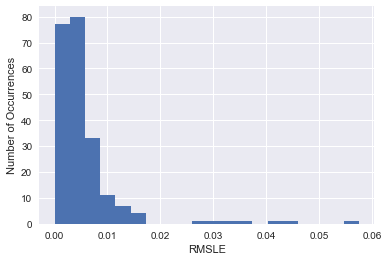

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yangweineo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,col,correlation
100,RoofMatl_Membran,0.503085
115,ExterCond_Fa,0.405905
111,ExterQual_Fa,0.380351
175,Functional_Mod,0.375512
145,BsmtFinType2_GLQ,0.362868
44,LandContour_Low,0.350333
220,Condition_Norm,-0.296761
208,SaleType_ConLD,0.285261
168,KitchenQual_Fa,0.284159
53,LandSlope_Sev,0.282551


In [242]:
# this still only works on individual models, it doens't average the correlations over a set of models
# this tool is really more exploratory than anything - look at a couple models from the set you care about
# and see what the trends are

# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
# use this variable to specify which in the list of models trained with that specification to use
model_to_use = df_and_row_to_use['Model'][1]
# don't change this
features_to_use = df_and_row_to_use['Features']

def create_error_correlation_table(model,
                                   outcome_var,
                                   feature_set,
                                   dev_df):
    
    '''
    finds correlation between absolute value of error
    and each feature
    '''
    
    final_data = {'col': feature_set}
    dev_df = dev_df.reset_index()
    
    dev_preds = model.predict(dev_df[feature_set])

    rmsles = []
    for i in range(len(dev_preds)):
        rmsles.append(sf.rmsle([dev_df[outcome_var][i]], [dev_preds[i]]))

    plt.clf()
    plt.hist(rmsles, bins=20)
    plt.xlabel("RMSLE")
    plt.ylabel("Number of Occurrences")
    plt.show()

    dev_df['linear_reg_errors'] = rmsles

    corrs = []
    for col in feature_set:
        try:
            cor = np.corrcoef(abs(dev_df['linear_reg_errors']), dev_df[col])[0,1]
            corrs.append(cor)
        except:
            pass

    final_data['correlation'] = corrs 
    
    corrs_df = pd.DataFrame(data=final_data)
    corrs_df = corrs_df.dropna()
    return corrs_df
  
# table for our LR with all the features
corrs_df = create_error_correlation_table(model_to_use, 'LogSalePrice', features_to_use, dev_df)
corrs_df.reindex(corrs_df.correlation.abs().sort_values(ascending=False).index)

### Plot Errors by Key Variables

In [243]:
# Creation of the error plot
import shared_functions as sf

def plot_error_against_var(model, outcome_var, feature_set, plot_features, dev_df):
    
    # Calculate predictions for each observation
    pred_LR = pd.DataFrame(model.predict(dev_df[feature_set]), columns = ['pred'])
    
    # Calculate error for each observation
    dev_df2 = pd.concat([dev_df.reset_index(drop=True), pred_LR], axis = 1)
    dev_df2['error'] = dev_df2['pred'] - dev_df2[outcome_var]
    
    # Plot Errors:
    col_count = 3
    row_count = len(plot_features)//col_count + 1

    fig, ax = plt.subplots(row_count, col_count, figsize = (row_count*3,row_count*3))

    for counter, var in enumerate(plot_features): 
        col_position = counter%col_count
        row_position = counter//col_count
#         try:
#             ax[row_position, col_position] = sns.regplot(x=var, y="error", x_jitter = True, data=dev_df2)
#         except:
#             ax[row_position, col_position] = sns.relplot(x=var, y="error", data=dev_df2)
        ax[row_position, col_position].scatter(dev_df2[var], dev_df2['error'])
        ax[row_position, col_position].axhline(y=0)
        ax[row_position, col_position].set_xlabel(var)
        ax[row_position, col_position].set_ylabel('error')
     
    fig.suptitle(model)
    fig.subplots_adjust(hspace=1)
    plt.show()

#### Cycle through each model variation and plot errors

In [244]:
### Random Forest
df.sort_values('Root MSE', ascending=True).head(1)

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
6,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[(DecisionTreeRegressor(criterion='mse', max_d...",232,LogSalePrice,"{'max_features': 200, 'min_samples_leaf': 3, '...",0.151481,0.082166


In [245]:
### Linear Regression
lrdf.sort_values('Root MSE', ascending=True).head(1)

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.14084,0.098798


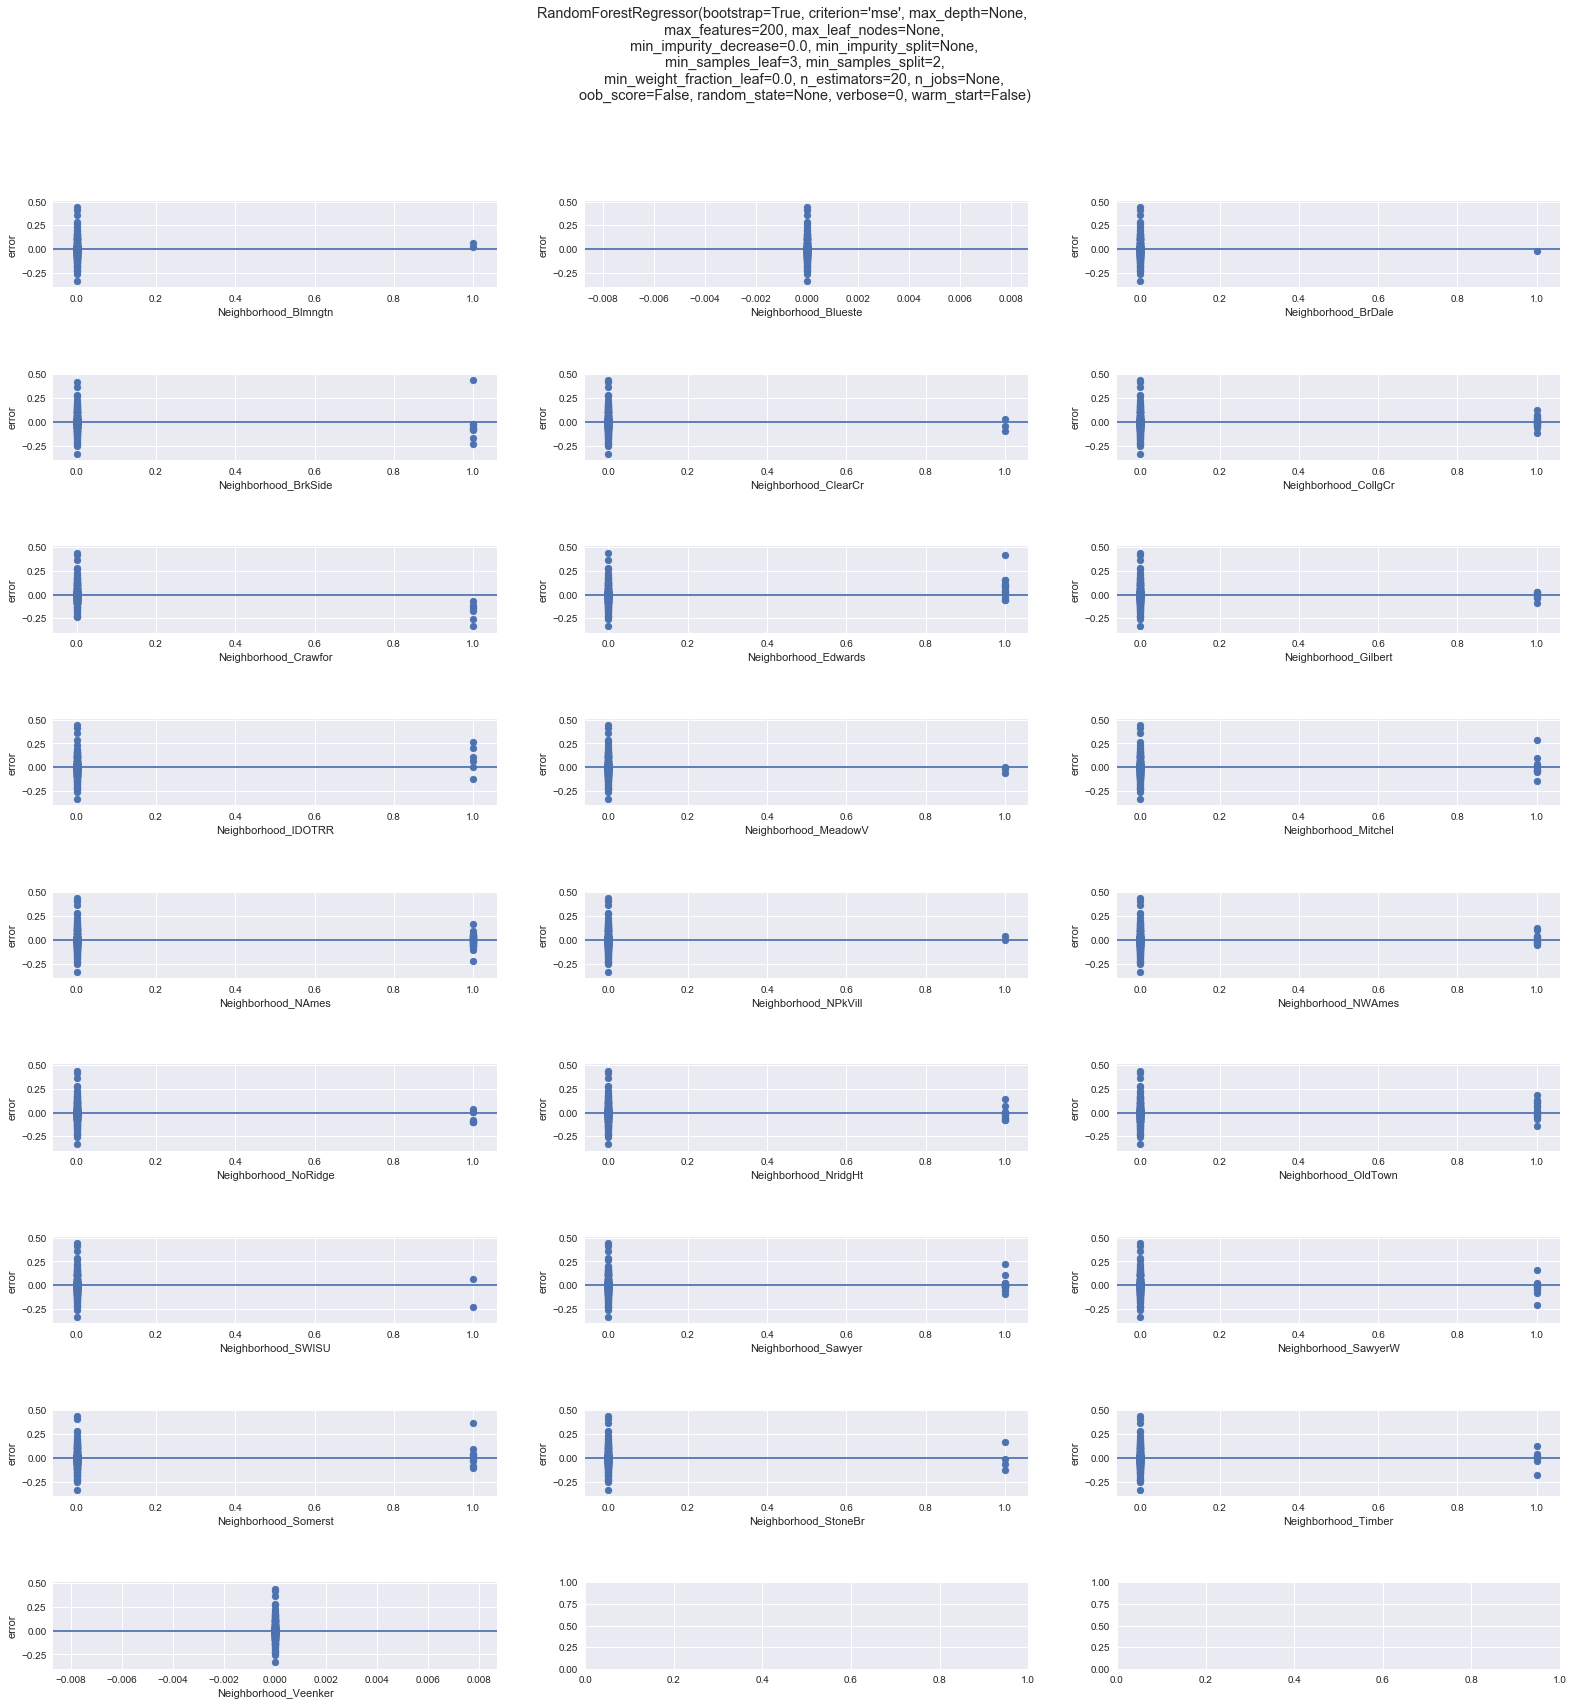

In [258]:
### Random Forest Errors
rf_error_spec = df.sort_values('Root MSE', ascending=True).iloc[0]
model_to_use = rf_error_spec['Model'][0]
features_to_use = rf_error_spec['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

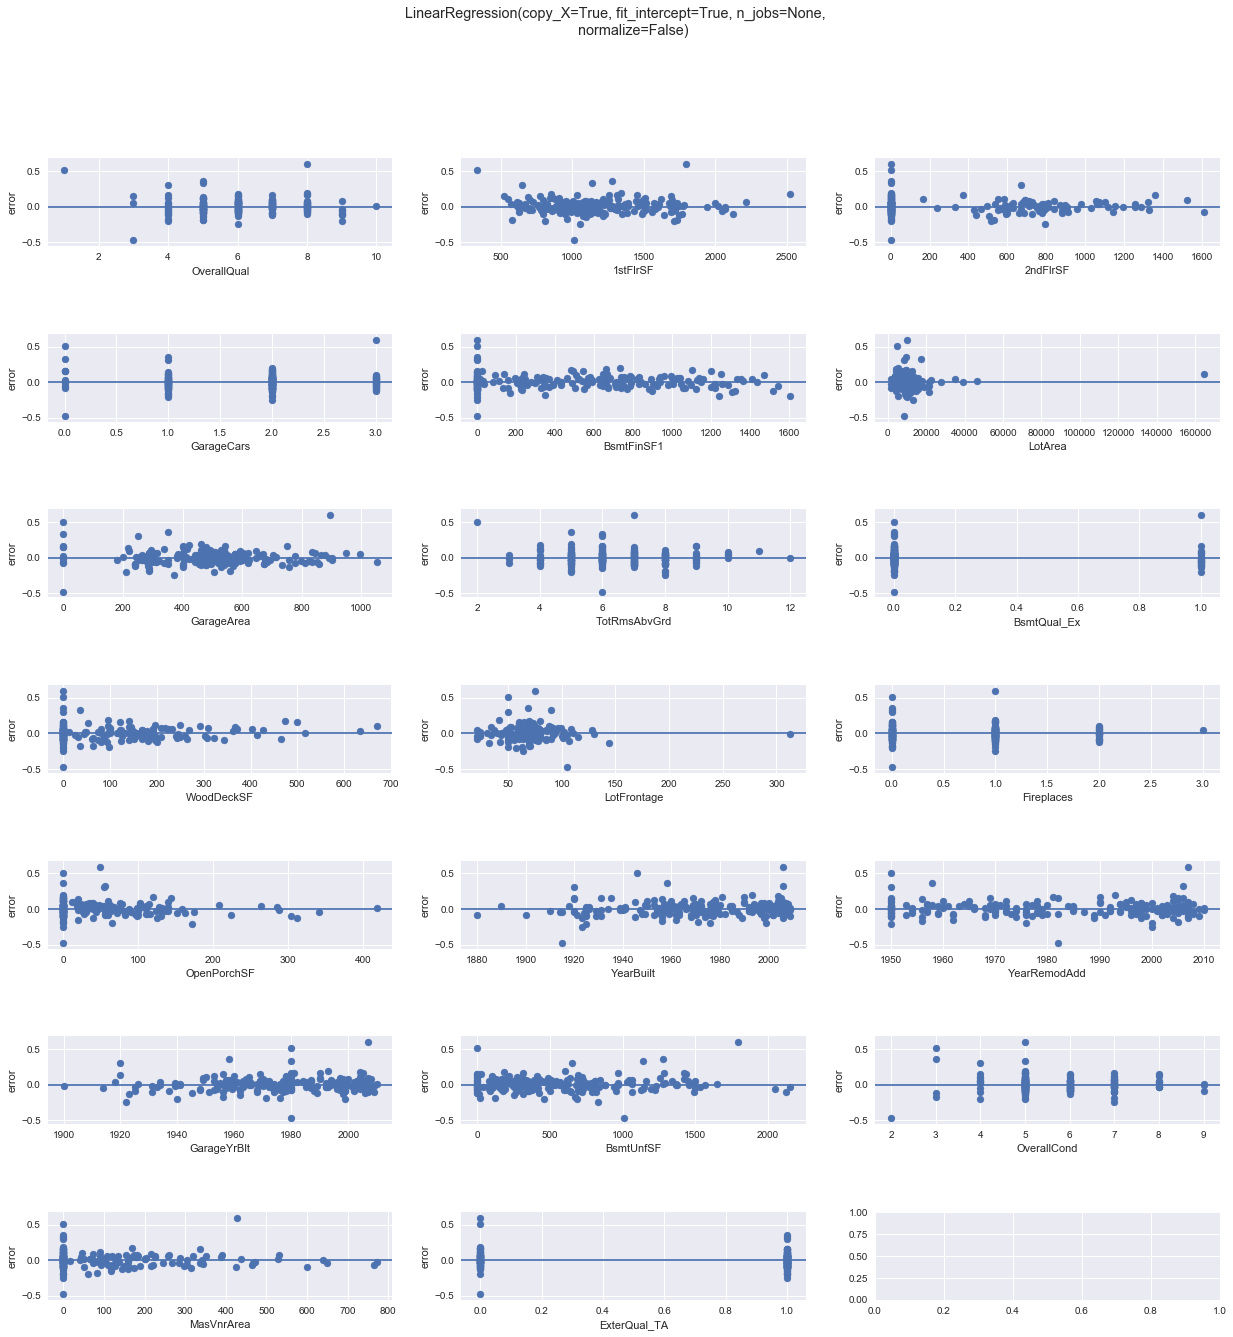

In [256]:
### Linear Regression Errors
# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
model_to_use = df_and_row_to_use['Model'][0]
features_to_use = df_and_row_to_use['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

### Deeper Dive into Modeling

This problem is asking us to predict the sale prices of homes that are randomly distributed within the dataset in terms of time. It is not asking to predict the sales prices for homes that will be sold in the future. In this way, the problem is not actually a useful real-world problem to solve. It isn't that useful to predict the sales prices of homes that have already been sold; a useful model would predict the prices of homes that will be sold in the future. In order to create a model that would make these future home price predictions, we would possibly need to exclude or weight differently the more recent data in our training set because we would want the recent data to play a bigger role in training the model.

There are different ways that the problem posed based on this data could be reformulated to make it more interesting or useful to stake-holders. To consider these, we break the context down into two different cases. First, we can consider the data and the problem from the perspective of a prospective home buyer. Next, we can consider the data and the problem from the perspective of a prospective home seller. There are different stake-holders within these groups as well, such as real estate agents or real estate developers, who might have different levels of interest or fluency with different features or models.

A key question for any home buyer is: What is the right price to offer for a given home? To answer this question, people spend a lot of time considering "comps" which are comparable properties or homes that they could use to estimate the market value of a home. An interesting reformulation of this problem would be to consider a model that uses clustering and filtering so that homes are only compared to similar homes based on key factors, such as the neighborhood, the location within the neighborhood (i.e. corner lot or on a quiet street), the size of the home and the year it was built. Typically, a home buyer would have already narrowed down their homes by neighborhood and other key factors, so a model that predicted prices within comparable properties would be most useful to prospective buyers.

A key question for any home seller is: What is the right price to ask for this home? Setting the asking price is more of an art than a science, but machine learning could change that. Sellers would not only want to know about what price a home will ultimately sell for, but also how to set the asking price to maximize this value. In order to answer this question, the model would not only need to be changed in order to predict future sale prices, but the data set would need to also include the asking prices of homes, so that the model could include information about the relationship between the asking price and the final sale price. 

There would be several key variables to be added to the dataset that would make these questions more answerable. First, more specific time information about home sales would be helpful. The current dataset only offers information to the month, not the day. Second, more specific information about the location would be helpful--we don't know which houses are on corner lots, or busy streets or quiet cul-de-sacs. This additional feature would allow for more analysis of the quality of the home's location. To make the location analysis most accurate, we would ideally have latitude and longitude data about the exact location of each home.

Finally, more information about larger economic trends would be helpful. While it is impossible to predict the future, trends in other economic indicators could have predictive value for future home prices. A model that was able to accurately predict future home prices would need to evaluate the predictive value of various other economic indicators.
